In [1]:
import tensorflow as tf
import numpy as np
from gbica_utils import *
from tf_powersfa import *
from tensorflow.keras.layers import *
from tensorflow.nn import *

In [2]:
n_out = 2
n_hidden = 128

In [3]:
batch_size = 1000
N = 998


encoding_x = tf.placeholder("float", [N, n_out])
with tf.name_scope("encoder"):
    dense0 = leaky_relu(tf.keras.layers.Dense(n_hidden)(encoding_x))
    dense1 = leaky_relu(tf.keras.layers.Dense(n_hidden)(dense0))
    dense2 = tf.keras.layers.Dense(n_out)(dense1)


encoder_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='encoder')

dense = alt_power_whitening(dense2, n_out, 50)[0]

In [4]:
n_hidden = 20

x, y = tf.split(dense, n_out, axis=1)

y_ = permute_y(y, N)

h_join = tf.concat([y, x], axis=1)
h_marg = tf.concat([y_, x], axis=1)
learning_rate_encoder = tf.placeholder(tf.float32, shape=[])
learning_rate_estimator = 0.005
with tf.name_scope("estimator"):
    estimator1 = Dense(n_hidden)
    estimator2 = Dense(n_hidden)
    estimator3 = Dense(n_hidden)
    estimator4 = Dense(n_hidden)
    estimator5 = Dense(n_hidden)
    
    def estimator_net_simple(h_join, h_marg, estimator): 
        dense1_joint = leaky_relu(estimator[0](h_join))
        dense2_joint = leaky_relu(estimator[1](dense1_joint))
        dense3_joint = leaky_relu(estimator[2](dense2_joint))
        dense4_joint = leaky_relu(estimator[3](dense3_joint))
        dense5_joint = estimator[4](dense4_joint)

        dense1_marg = leaky_relu(estimator[0](h_marg))
        dense2_marg = leaky_relu(estimator[1](dense1_marg))
        dense3_marg = leaky_relu(estimator[2](dense2_marg))
        dense4_marg = leaky_relu(estimator[3](dense3_marg))
        dense5_marg = estimator[4](dense4_marg)
        return dense5_joint, dense5_marg
    
    dense5_joint, dense5_marg = estimator_net_simple(h_join, h_marg,
                                                   [estimator1, estimator2, estimator3, estimator4, estimator5])

estimator_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='estimator')


regularizer = tf.contrib.layers.l2_regularizer(scale=0.005)

for var in estimator_var_list:
    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, var)
reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)


loss = tf.reduce_mean(dense5_joint)-tf.log(tf.reduce_mean(tf.exp(dense5_marg)))
train_encoder     = tf.train.AdamOptimizer(learning_rate_encoder).minimize(loss, var_list=encoder_var_list)
train_step = tf.contrib.opt.NadamOptimizer(learning_rate_estimator).minimize(-(loss+reg_term), var_list=estimator_var_list)

/home/hlynur/.local/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:305: UserWarning: n_components is too large: it will be set to 2
  warnings.warn('n_components is too large: it will be set to %s' % n_components)


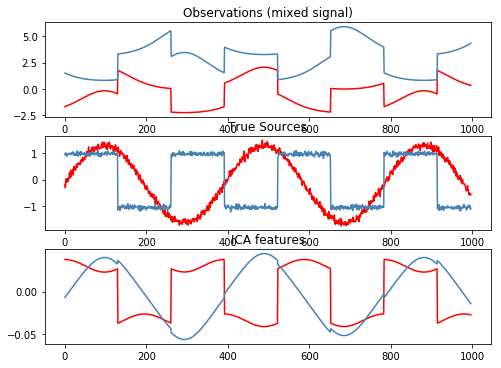

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA

time = np.linspace(0, 8, batch_size)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s1 -= np.mean(s1)
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s2 -= np.mean(s2)
S = np.c_[s1, s2]
S += 0.05 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1], [0.5, 2]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

for t in range(X.shape[0]):    
    X[t, 0] = np.exp(s1[t]) - np.exp(s2[t])
    X[t, 1] = np.exp(-s1[t]) + np.exp(-s2[t])
S = S[1:-1,:]
X = X[1:-1,:]

# Solve the task with FastICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals


models = [X, S, S_]
names = ['Observations (mixed signal)', 'True Sources', 'ICA features']
colors = ['red', 'steelblue']
plt.figure(figsize=(8, 8))
for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
plt.show()

step: 0, loss: 0.0017252108082175255


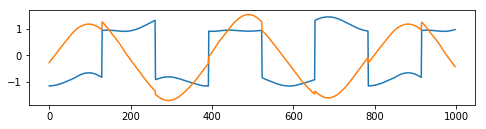

step: 15, loss: 0.01036510057747364
step: 30, loss: -0.005303569138050079


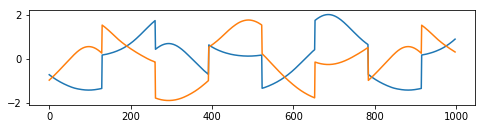

step: 45, loss: 0.06332491338253021
step: 60, loss: 0.3651059865951538
step: 75, loss: 0.1935310959815979


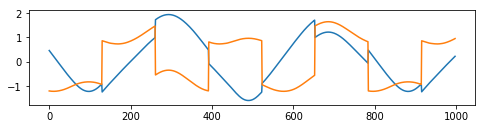

step: 90, loss: 0.35185694694519043
step: 105, loss: 0.7818155288696289
step: 120, loss: 1.117539644241333


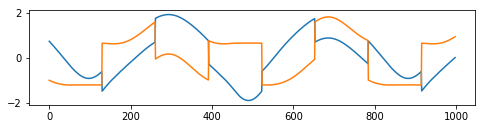

step: 135, loss: 0.7797098159790039
step: 150, loss: 0.5599184036254883


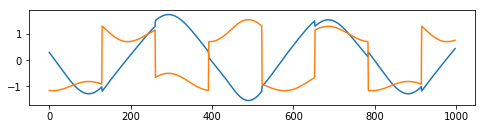

step: 165, loss: 0.6599555015563965
step: 180, loss: 0.6994819641113281
step: 195, loss: 0.7499966621398926


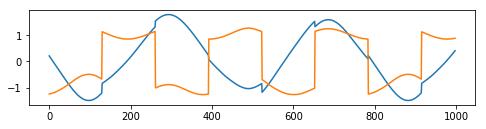

step: 210, loss: 0.9726057052612305
step: 225, loss: 0.6802806854248047
step: 240, loss: 1.0843467712402344


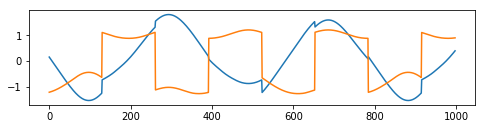

step: 255, loss: 1.0789833068847656
step: 270, loss: 1.055145263671875


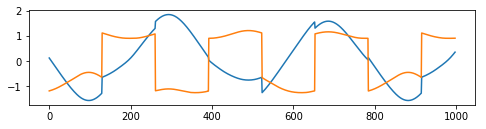

step: 285, loss: 1.0713682174682617
step: 300, loss: 1.2465095520019531
step: 315, loss: 0.9252357482910156


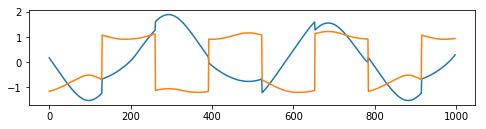

step: 330, loss: 1.3091402053833008
step: 345, loss: 0.9988174438476562
step: 360, loss: 1.1446619033813477


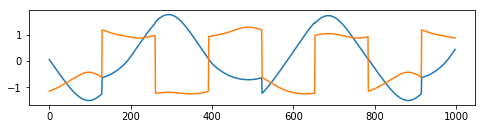

step: 375, loss: 1.4838018417358398
step: 390, loss: 1.0753402709960938


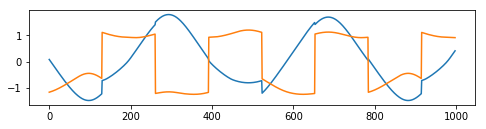

step: 405, loss: 1.2153959274291992
step: 420, loss: 1.5097637176513672
step: 435, loss: 1.2030563354492188


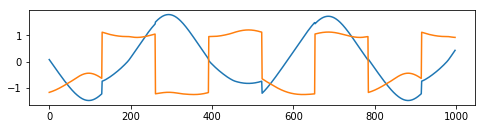

step: 450, loss: 1.4523601531982422
step: 465, loss: 1.1071815490722656
step: 480, loss: 1.3090457916259766


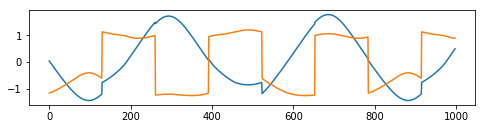

step: 495, loss: 1.4820575714111328
step: 510, loss: 1.234903335571289


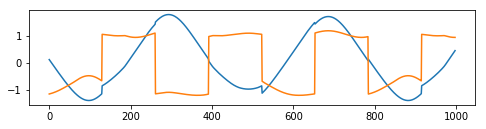

step: 525, loss: 0.8288192749023438
step: 540, loss: 1.1747627258300781
step: 555, loss: 0.4250602722167969


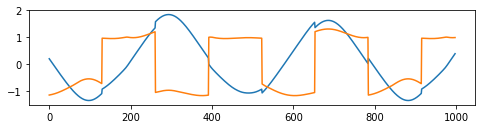

step: 570, loss: 1.0081233978271484
step: 585, loss: -0.2915916442871094
step: 600, loss: 1.096261978149414


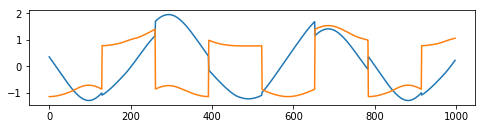

step: 615, loss: 1.0056724548339844
step: 630, loss: 1.4301490783691406


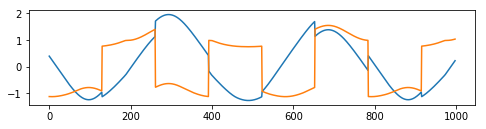

step: 645, loss: 1.2778282165527344
step: 660, loss: 1.1647148132324219
step: 675, loss: 1.1177387237548828


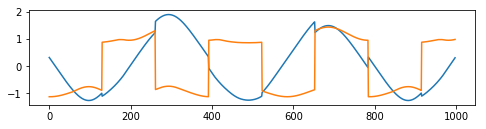

step: 690, loss: 0.8676261901855469
step: 705, loss: 1.154867172241211
step: 720, loss: 1.0316028594970703


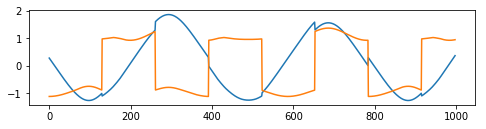

step: 735, loss: 0.8190860748291016
step: 750, loss: 0.8192996978759766


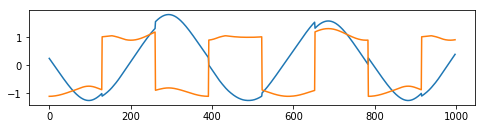

step: 765, loss: 0.6071052551269531
step: 780, loss: 1.1680622100830078
step: 795, loss: 0.9365081787109375


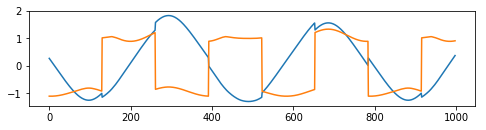

In [6]:
shuffled_x = np.array(X)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(801):
        current_loss, _ = sess.run([loss, train_step], feed_dict={encoding_x:shuffled_x})
        np.random.shuffle(shuffled_x)
        if i % 4 is 0: 
            current_loss, _ = sess.run([loss, train_encoder], feed_dict={encoding_x:shuffled_x, 
                                                                        learning_rate_encoder:0.004 / (1+0.01*i)})
        if i % 15 is 0: print("step: {}, loss: {}".format(i, current_loss))         
        if i % 40 is 0:
            #v = sess.run(Wx)
            plt.figure(figsize=(8, 8))
            plt.subplot(4, 1, 1)
            encoding = sess.run(dense, feed_dict={encoding_x:X})
            plt.plot(encoding)
            plt.show()